# MLND Project notebook

This notebook is the base version of my project. Seeds, algorithms, epochs, etc. can be modified to validate the results from my project paper. I used this notebook on my personal computer in addition to running another version on an AWS instance to get all the results. Total CPU running time exceeds 100+ CPU hours. Moreover, I used a GPU instance for the more complex calculations. 

Note that the current version of `MXNet` as well as `gluonts` is required to be installed on the computer or the AWS instance. After installing `MXNet` using pip or conda (not necessary on AWS SageMaker instances), the most recent version of the  `gluonts` library can installed by directly accessing the github code using 

`!pip install git+https://github.com/awslabs/gluon-ts.git`

The github of the project in conjunction with the GluonTS documentation was very helpful. Moreover, note that I used Ubuntu Linux instances.

## Imports

After making sure that `MXNet` is installed on the computer or instance, run the following command to install the most recent version of gluonts. 

For more information follow the installation guide: 

- [Installation guide](http://gluon-ts-staging.s3-accelerate.dualstack.amazonaws.com/PR-271/4/install.html)


The gluonts version that I used for the project:

- `0.3.4.dev68+ga894aee`


In [3]:
import gluonts
gluonts.__version__

'0.3.3'

**If gluonts version is <= 0.3.3 uncomment the following line and install gluonts github version directly**

Note that this may require additional dependencies.

In [ ]:
# If gluonts version is <= 0.3.3: uncomment the following line
# !pip install git+https://github.com/awslabs/gluon-ts.git

In [27]:
# visualization 
%matplotlib inline
import matplotlib.pyplot as plt

# standard imports
import numpy as np
import pandas as pd

# mxnet imports 
import mxnet as mx
from mxnet import gluon

# json library
import json

# gluon imports
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

import random

## The data

There are various ways to work with the M4 data in python. Initially I downloaded the data from the original website and had to prepare them in order to use them. I later realised that there is a neat library that has a built-in function.

The data can be loaded using the `get_dataset(...)` function. This project coverst the performance of the following data: 

- `m4_hourly`
- `m4_daily`
- `m4_weekly`
- `m4_daily`

Built-in datasets of gluonts are objects that consists of three parts: 

- `dataset.train` - is an iterable collection of data entries used for training. Each entry is one series as a dictionary.
- `dataset.test`- The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length (forecasting horizon in the M4 competition). 
- `dataset.metadata` - contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon (forecast horizon), associated features, etc. 

In [14]:
# load data
dataset = get_dataset("m4_hourly")

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_hourly.


Each entry consists of at least a starting timestamp with respective  frequency of the series, and the target time series. In the case of the M4 data the starting time is a generic starting time which is equal for all time series as the starting dates were not known during the competition.  

In [35]:
entry = list(dataset.train)[0]

print("Start:\n", entry["start"])
print("First ten observations:\n", entry["target"][:10])

Start:
 1750-01-01 00:00:00
First ten observations:
 [605. 586. 586. 559. 511. 443. 422. 395. 382. 370.]


## Example plot

Series No.: 338


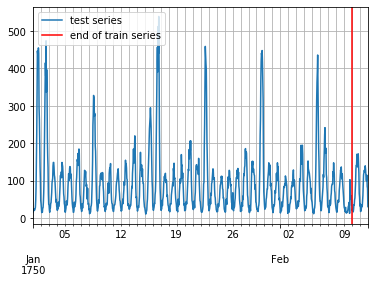

In [34]:
rn = random.randint(0, len(dataset.train))
print("Series No.:", rn)
train_series = to_pandas(list(dataset.train)[rn])
test_series = to_pandas(list(dataset.test)[rn])

test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()